# Training a neural network model to generate a document deformation mesh in an image.

Author: Maciej Kubiś

Date: 2025-03-24

The notebook will allow training of various AI models created using **PyTorch**. Various architectures modeled on **U-Net** will be tested.

In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
sys.path.append("../src") 

from data_generator import DocumentImageGenerator
from neuralnet_handler import NeuralNetHandler
from unet_flexible import UNetFlexible

## Configuration

It is possible to set device where will be handle neural network. Image generator require file with any text to produce random content of documents.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = DocumentImageGenerator("../src/assets/text.txt")

nn_handler = NeuralNetHandler(None, generator, device, 3000, 0.01, 20)

Using device: cpu
Model is None. Please provide a valid model using set_model() method.


## U-Net model


The `UNetFlexible` is a custom implementation of the U-Net architecture designed for grid regression (e.g., predicting (x, y) offsets per pixel). It is built to work with **arbitrary input image sizes**, not just those that are powers of 2.

### Architecture Overview

- **Encoder**: 3 convolutional blocks with downsampling (`MaxPool2d`), each doubling the number of channels.
- **Bottleneck**: A deeper feature extractor that expands feature capacity.
- **Decoder**: 3 upsampling blocks using `bilinear interpolation`, followed by `Conv2d` layers and skip connections.
- **Final Output**: A `1x1 Conv2d` layer projecting to 2 channels (for `(x, y)` offset prediction per pixel).

### Skip Connections

The model uses **skip connections** with dynamic interpolation (`F.interpolate`) to **align spatial dimensions** when concatenating encoder and decoder feature maps — this ensures compatibility with **any image size**, including those **not divisible by powers of 2**.

### Output Behavior

- Input shape: `(N, 1, H, W)` — single-channel grayscale images.
- Output shape: `(N, 2, H, W)` — two-channel output with predicted `(x, y)` offsets for each pixel.

### Customization

- `base_channels`: Controls the number of filters in the first encoder block (default = 64).
- Fully convolutional — supports dynamic image sizes at inference without needing resizing to specific dimensions.

In [3]:
model = UNetFlexible(base_channels=64)  # You can adjust base_channels as needed
nn_handler.set_model(model, "unet_deform")

print(model)

UNetFlexible(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

#### Function for plotting results:

In [4]:
def plot():
    # Clear the output before plotting
    clear_output(wait=True)

    # Plot training progress
    plt.figure(figsize=(10, 4))
    plt.plot(nn_handler.get_train_losses(), label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss (U-Net)')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

    # Plot validation progress
    plt.figure(figsize=(10, 4))
    plt.plot(nn_handler.get_val_losses(), label='Validation Loss', color='green')
    plt.xlabel('Evaluation Steps (every 60 epochs)')
    plt.ylabel('Loss')
    plt.title('Validation Loss (U-Net)')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

### Training and results

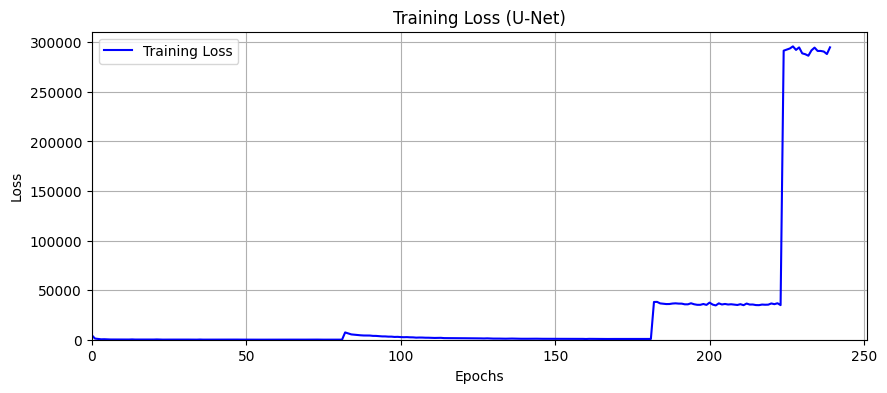

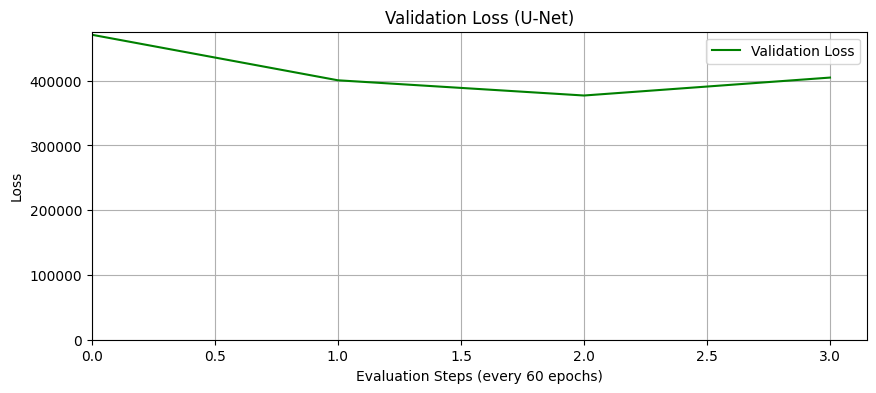

In [5]:
nn_handler.train(resume_from_checkpoint=True)

plot()

#### Ensure model save

In [ ]:
nn_handler.save_model("../models/unet_deform.pth")

Model saved to ../models/unet_deform.pth
